In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from fastai.tabular.all import *
import shap


import xgboost as xgb
from sklearn.metrics import accuracy_score

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [2]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Data Visualization 

First, we want to visualize and understand the data we're working with. The train and test datasets contain information on passengers of the Titanic.
The columns are listed below and explained further in this Notebook 

In [3]:
train_data.columns.to_list()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Counting the NANs, there is missing data in the `Age` column and a significant amount of missing data in the `Cabin` column. We'll consider how to deal with that later.

In [6]:
train_data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [7]:
len(train_data)

891

# Data/Exploration and Feature Engineering

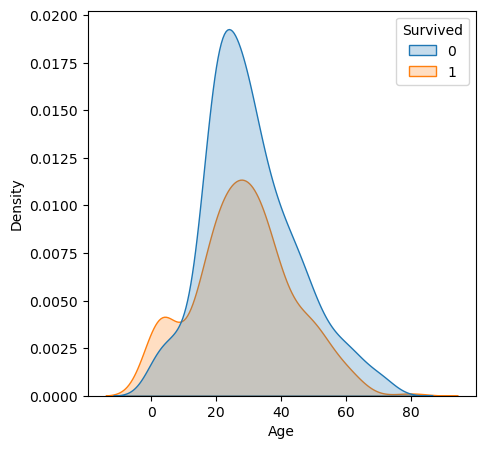

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
sns.kdeplot(data=train_data,x='Age',shade=True,hue='Survived');

A small spike of being between 0-20 led to a higher rate of survival. 

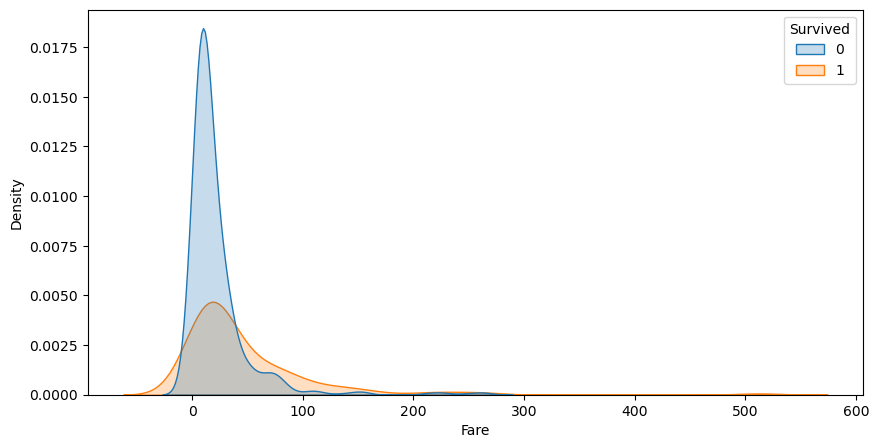

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=train_data,x='Fare',shade=True,hue='Survived');

We see a higher fare also gave a higher rate of survival.

In [10]:
# Defining a plotting function I will use often for categorical columns. 
# It's useful to know both the rate of survival and the number of passengers 
# in each category.

def plot_categorical(dataset, column, title):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.barplot(data=dataset, x=column, y='Survived', 
                ci=None, ax=ax1,palette='tab20b').set_ylabel('Survival rate')
    
    sns.countplot(data=dataset, x=column,hue="Survived",
                  ax=ax2).set_ylabel('Counts')
    
    plt.legend(loc='upper right', title='Survived')
    plt.suptitle(title)

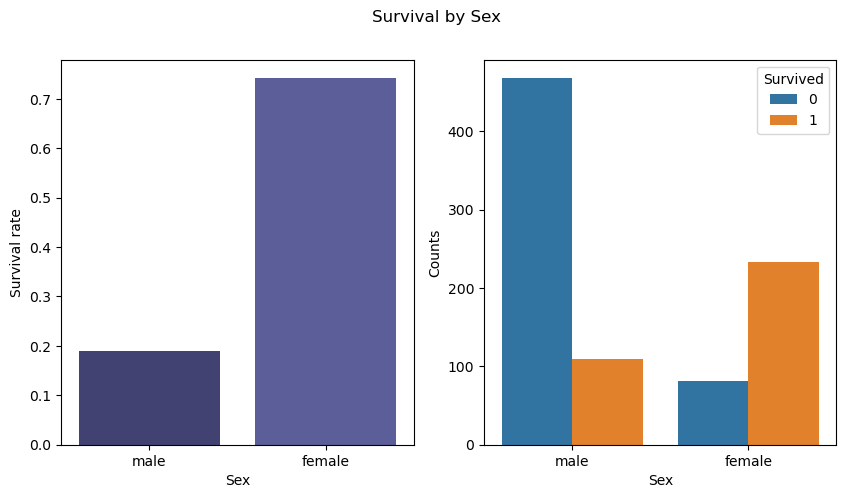

In [11]:
plot_categorical(train_data,'Sex','Survival by Sex')

We see the distributions of survival. Females had a better rate of survival! 

In [12]:
def plot_quartiles(dataset, column, title, categories):
    ranges = pd.qcut(dataset[column], len(categories), labels=categories)
    plot_categorical(dataset,ranges,title)

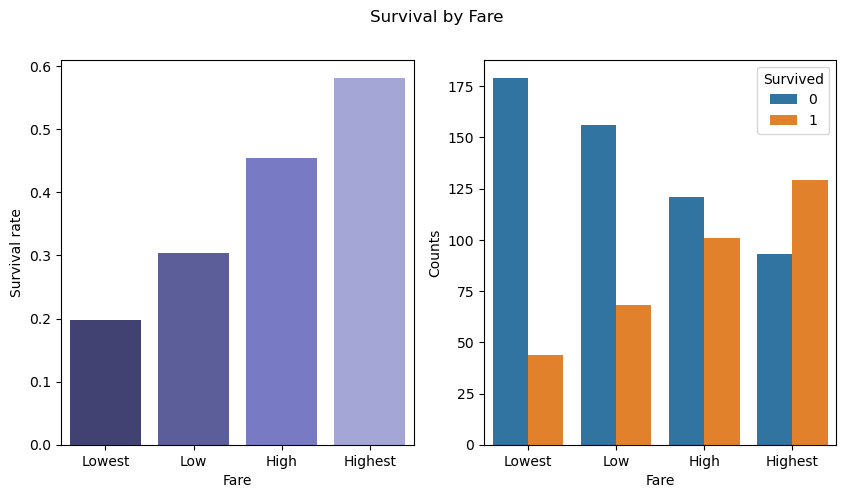

In [13]:
fare_categories = ['Lowest','Low','High','Highest']
plot_quartiles(train_data, "Fare","Survival by Fare",fare_categories)

Now we get to see the ranges of survival based on the fare rate! We see a lower rate of survival with a low fare. 

Let's investigate a new class. We know female/male, but let's look at the children too.

In [14]:
# Designate all children as "child" regardless of gender
train_data['Passenger'] = train_data.apply(lambda x: "child" if x['Age'] < 13 else x['Sex'],axis=1)
test_data['Passenger'] = test_data.apply(lambda x: "child" if x['Age'] < 13 else x['Sex'],axis=1)

In [15]:

def plot_categorical_by_gender(dataset, column, title):
    plot_categorical(train_data,column,title)
    g = sns.catplot(x=column,hue='Survived', col = 'Passenger', data=train_data,
                kind='count', aspect=.8, ci=None)
    g.set_axis_labels(column,'Counts') 
    g.despine(right=False,top=False)

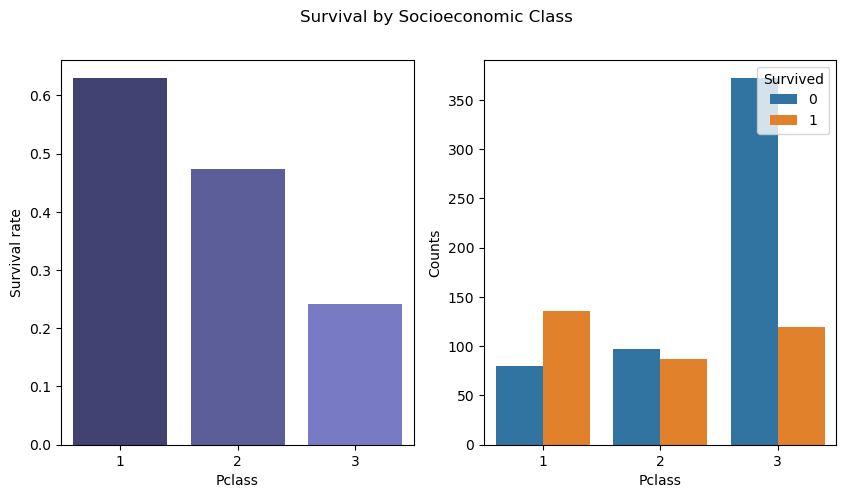

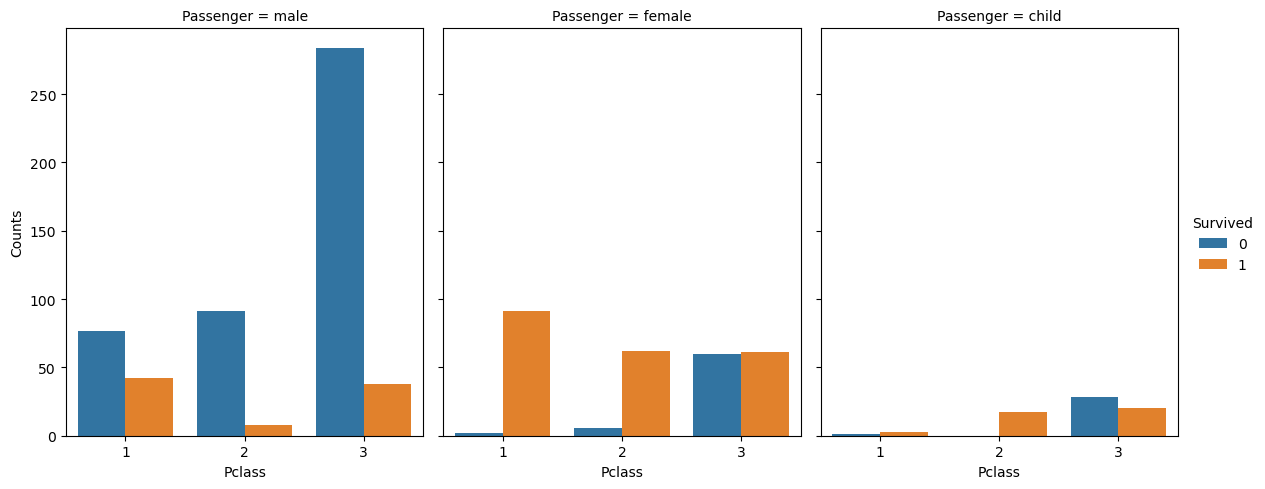

In [16]:
plot_categorical_by_gender(train_data,'Pclass','Survival by Socioeconomic Class')

We notice that females regardless of class had a equal chance of not surviving. Males did not have a good chance of surviving in the third class.  

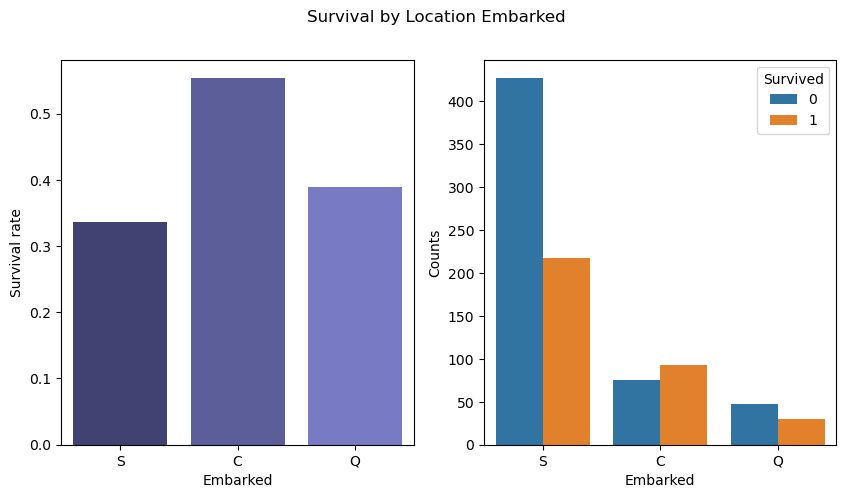

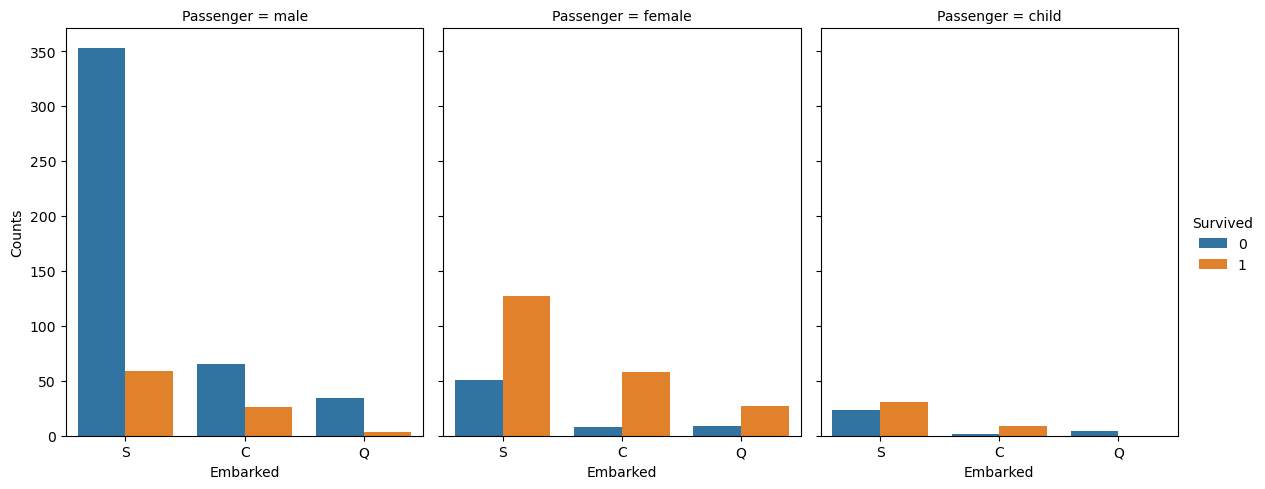

In [17]:
plot_categorical_by_gender(train_data,'Embarked','Survival by Location Embarked')

We notice that males did not survive well when they embarked from S. 

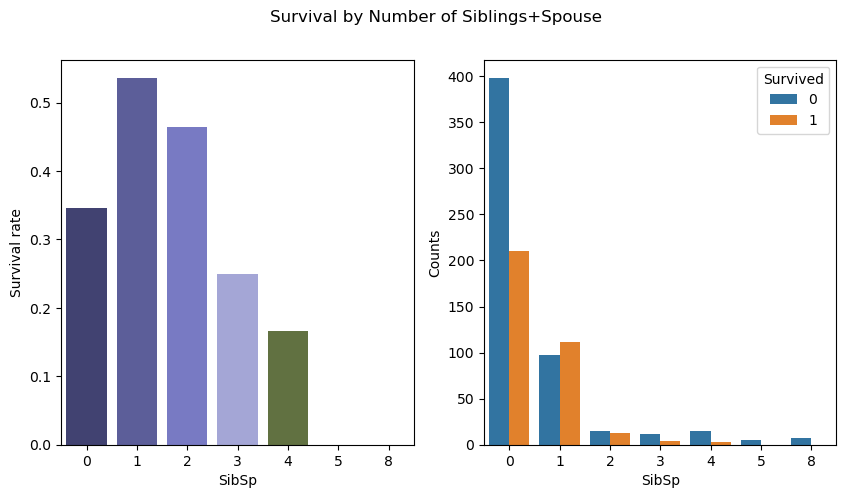

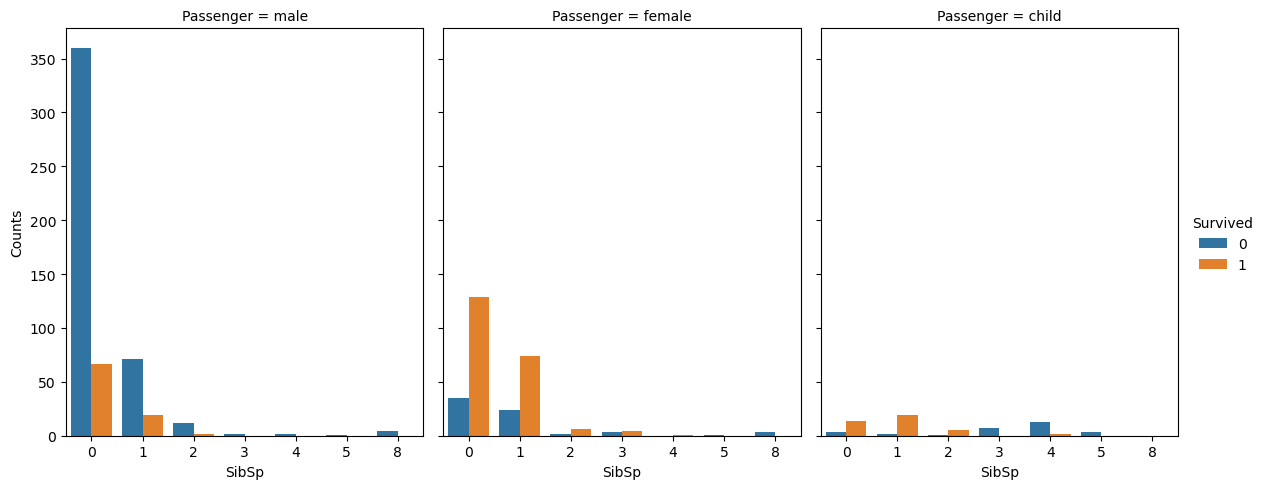

In [18]:
plot_categorical_by_gender(train_data,'SibSp','Survival by Number of Siblings+Spouse')

We notice that around the board, from males to females to children, that when the have a small family size, they have a higher rate of survival. 

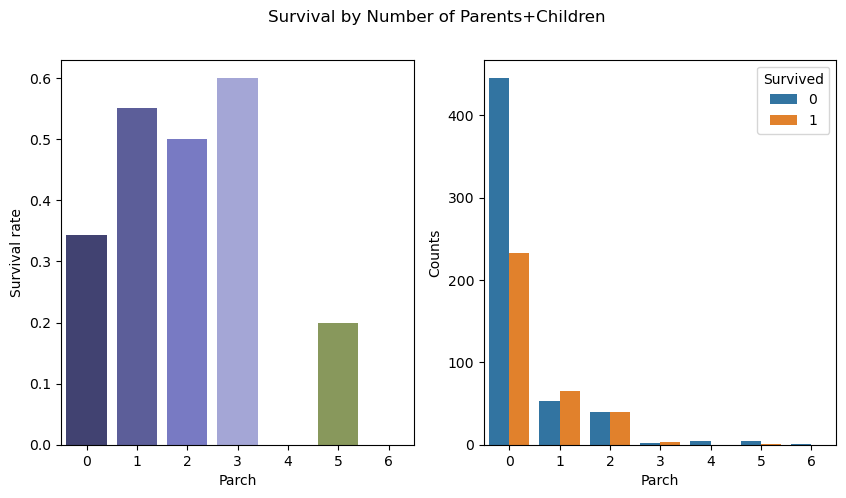

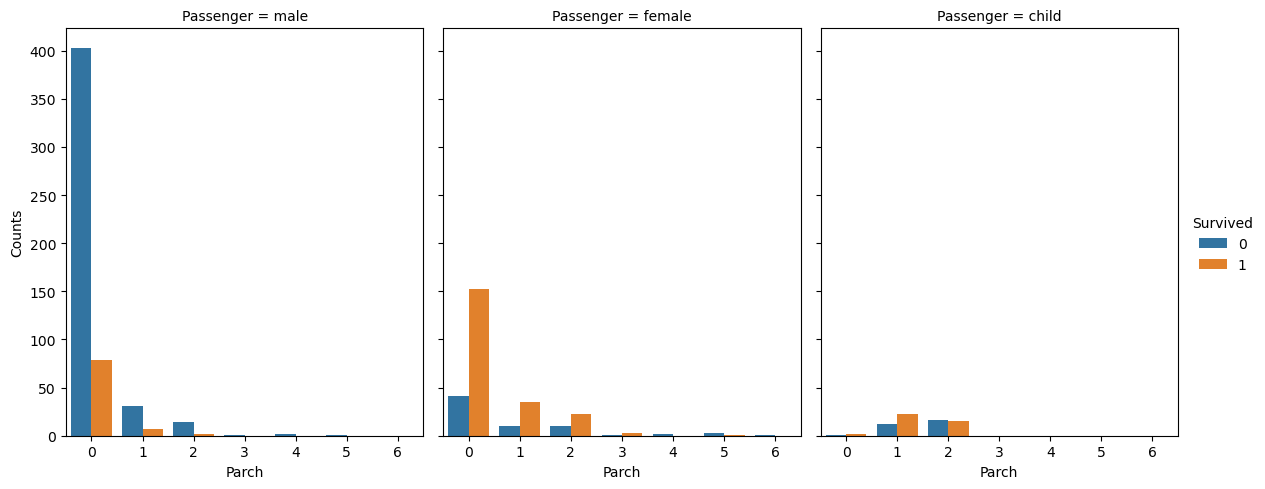

In [19]:
plot_categorical_by_gender(train_data,'Parch','Survival by Number of Parents+Children')

Similarly, larger family size leads to a lower rate of survival. 

In [20]:
# Define fare categories by quartile
fare_categories = ['Lowest','Low','High','Highest']
train_data['FareRange'] = pd.qcut(train_data['Fare'], len(fare_categories), labels=fare_categories)
test_data['FareRange'] = pd.qcut(test_data['Fare'], len(fare_categories), labels=fare_categories)

In [21]:
# Combine 'Parch' and 'SipSp' as Family plus 1 for the passenger
train_data['Family'] = train_data['Parch']+train_data['SibSp']+1
test_data['Family'] = test_data['Parch']+test_data['SibSp']+1

# Group into family types
train_data['FamilySize'] = pd.cut(train_data.Family,[0,1,4,7,11],labels=['Solo','Small','Big','Huge'])
test_data['FamilySize'] = pd.cut(test_data.Family,[0,1,4,7,11],labels=['Solo','Small','Big','Huge'])

In [22]:
# Let's change the Names to something more understandable. 
train_data["Title"] = train_data["Name"].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data["Title"] = test_data["Name"].apply(lambda x: x.split(',')[1].split('.')[0].strip())

title_filter = (lambda x: "Mrs" if (x=="the Countess" 
                                    or x=="Dona" 
                                    or x=="Mme" 
                                    or x=="Ms" 
                                    or x=="Mlle"
                                    or x=="Lady") 
                else       "Mr" if (x=="Don" 
                                    or x=="Col" 
                                    or x=="Major" 
                                    or x=="Capt" 
                                    or x=="Sir" 
                                    or x=="Jonkheer") 
                else x)

train_data["Title"] = train_data["Title"].apply(title_filter)
test_data["Title"] = test_data["Title"].apply(title_filter)

In [23]:
train_data['CabinSection'] = train_data.Cabin.apply(lambda x: x[0] if pd.notna(x) else x)
test_data['CabinSection'] = test_data.Cabin.apply(lambda x: x[0] if pd.notna(x) else x)

# Outlier category 'T' that doesn't exist in test set replaced by NaN
train_data['CabinSection'] = train_data['CabinSection'].where(train_data['CabinSection']!='T')

train_data['CabinNum'] = train_data.Cabin.astype(str).apply(lambda x: x.count(" ")+1 if pd.notna(x) else x)
test_data['CabinNum'] = test_data.Cabin.astype(str).apply(lambda x: x.count(" ")+1 if pd.notna(x) else x);

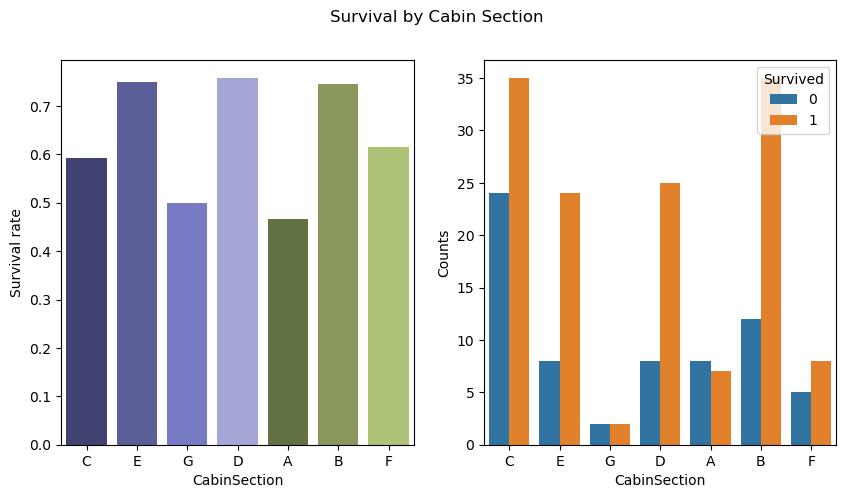

In [24]:
plot_categorical(train_data,'CabinSection','Survival by Cabin Section')

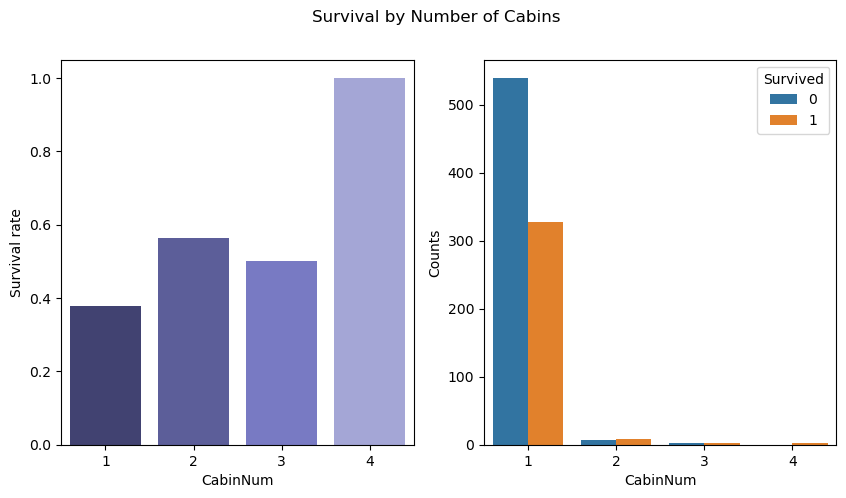

In [25]:
plot_categorical(train_data,'CabinNum','Survival by Number of Cabins')

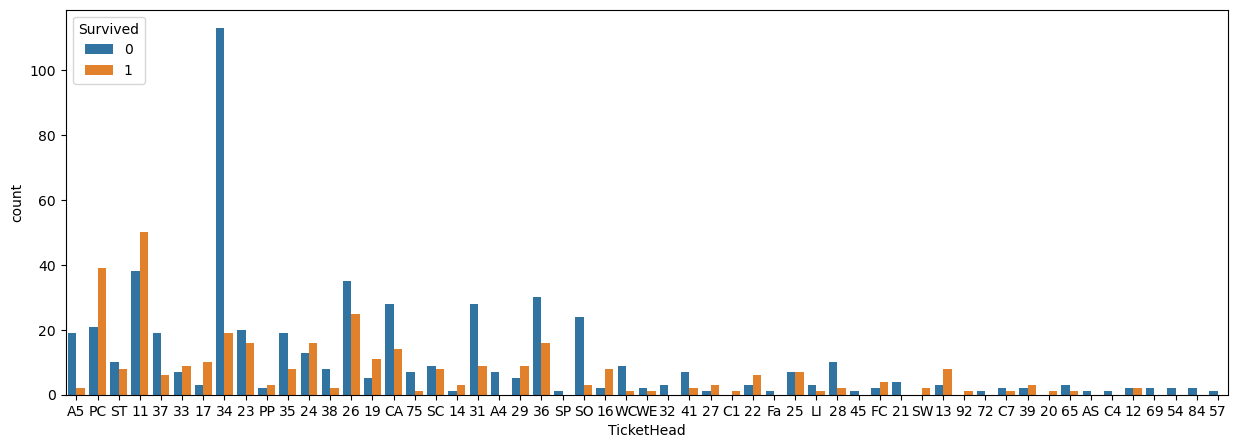

In [26]:
import re

# First removing all non-alphanumeric characters, and then saving the first two.

train_data['TicketHead'] = train_data.Ticket.astype(str).apply(lambda x: re.sub(r'\W+', '', x)[:2])
test_data['TicketHead'] = test_data.Ticket.astype(str).apply(lambda x: re.sub(r'\W+', '', x)[:2])

fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(data = train_data, x='TicketHead', hue="Survived");

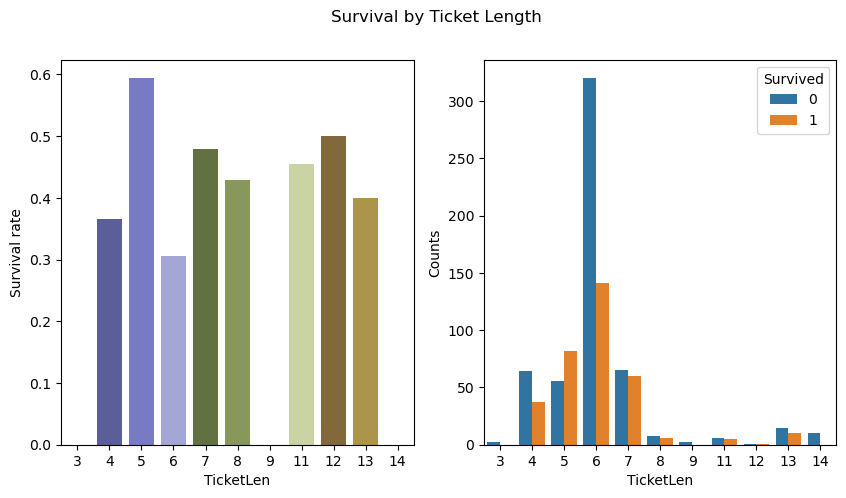

In [27]:
train_data['TicketLen'] = train_data.Ticket.astype(str).apply(lambda x: len(re.sub(r'\W+', '', x)))
test_data['TicketLen'] = test_data.Ticket.astype(str).apply(lambda x: len(re.sub(r'\W+', '', x)))

plot_categorical(train_data,'TicketLen','Survival by Ticket Length')

In [28]:
train_data.columns.to_list()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Passenger',
 'FareRange',
 'Family',
 'FamilySize',
 'Title',
 'CabinSection',
 'CabinNum',
 'TicketHead',
 'TicketLen']

In [29]:
features = ["Sex","Passenger","Pclass", "FamilySize", "FareRange", "Embarked",
            "Title","CabinSection", "CabinNum","TicketLen","TicketHead", "Fare", "Age", "Parch", "SibSp"]

In [30]:

train_data_sb = train_data[features].copy()
X_test_sb = test_data[features].copy()
train_data_sb["Survived"] = train_data["Survived"].copy()

In [31]:
train_data_sb

,Sex,Passenger,Pclass,FamilySize,FareRange,Embarked,Title,CabinSection,CabinNum,TicketLen,TicketHead,Fare,Age,Parch,SibSp,Survived
0,male,male,3,Small,Lowest,S,Mr,NaN,1,7,A5,7.2500,22.0,0,1,0
1,female,female,1,Small,Highest,C,Mrs,C,1,7,PC,71.2833,38.0,0,1,1
2,female,female,3,Solo,Low,S,Miss,NaN,1,13,ST,7.9250,26.0,0,0,1
3,female,female,1,Small,Highest,S,Mrs,C,1,6,11,53.1000,35.0,0,1,1
4,male,male,3,Solo,Low,S,Mr,NaN,1,6,37,8.0500,35.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,male,male,2,Solo,Low,S,Rev,NaN,1,6,21,13.0000,27.0,0,0,0
887,female,female,1,Solo,High,S,Miss,B,1,6,11,30.0000,19.0,0,0,1
888,female,female,3,Small,High,S,Miss,NaN,1,6,WC,23.4500,NaN,2,1,0
889,male,male,1,Solo,High,C,Mr,C,1,6,11,30.0000,26.0,0,0,1


In [32]:
dep_var = 'Survived'



splits= TrainTestSplitter(test_size=.3, random_state=42, shuffle=True, stratify=train_data_sb['Survived'])((train_data_sb)) 

In [33]:
procs = [Categorify, Normalize, FillMissing]


In [34]:
cat_names = ['Sex',
 'Passenger',
 'Pclass',
 'FamilySize',
 'FareRange',
 'Embarked',
 'Title',
 'CabinSection',
 'CabinNum',
 'TicketHead']

In [35]:
cont_names = ['Fare', 'Age',  'Parch', 'SibSp', 'TicketLen']

In [36]:
to = TabularPandas(train_data_sb, procs, cat_names = cat_names, cont_names = cont_names, y_names=dep_var, splits=splits, y_block = CategoryBlock)
xs,y = to.train.xs,to.train.y 
valid_xs,valid_y = to.valid.xs,to.valid.y
len(to.train),len(to.valid)

(623, 268)

In [37]:
X_train, y_train = xs, to.train.ys.values.ravel()
X_val, y_val = valid_xs, to.valid.ys.values.ravel()

In [38]:

model = xgb.XGBClassifier(eta = .2, max_depth=4,  tree_method = 'hist', enable_categorical = 'True')

xgb_model = model.fit(X_train, y_train,verbose=False)


In [39]:
xgb_preds = xgb_model.predict(X_val)

accuracy_score(y_val,xgb_preds) 

0.7947761194029851

<AxesSubplot:>

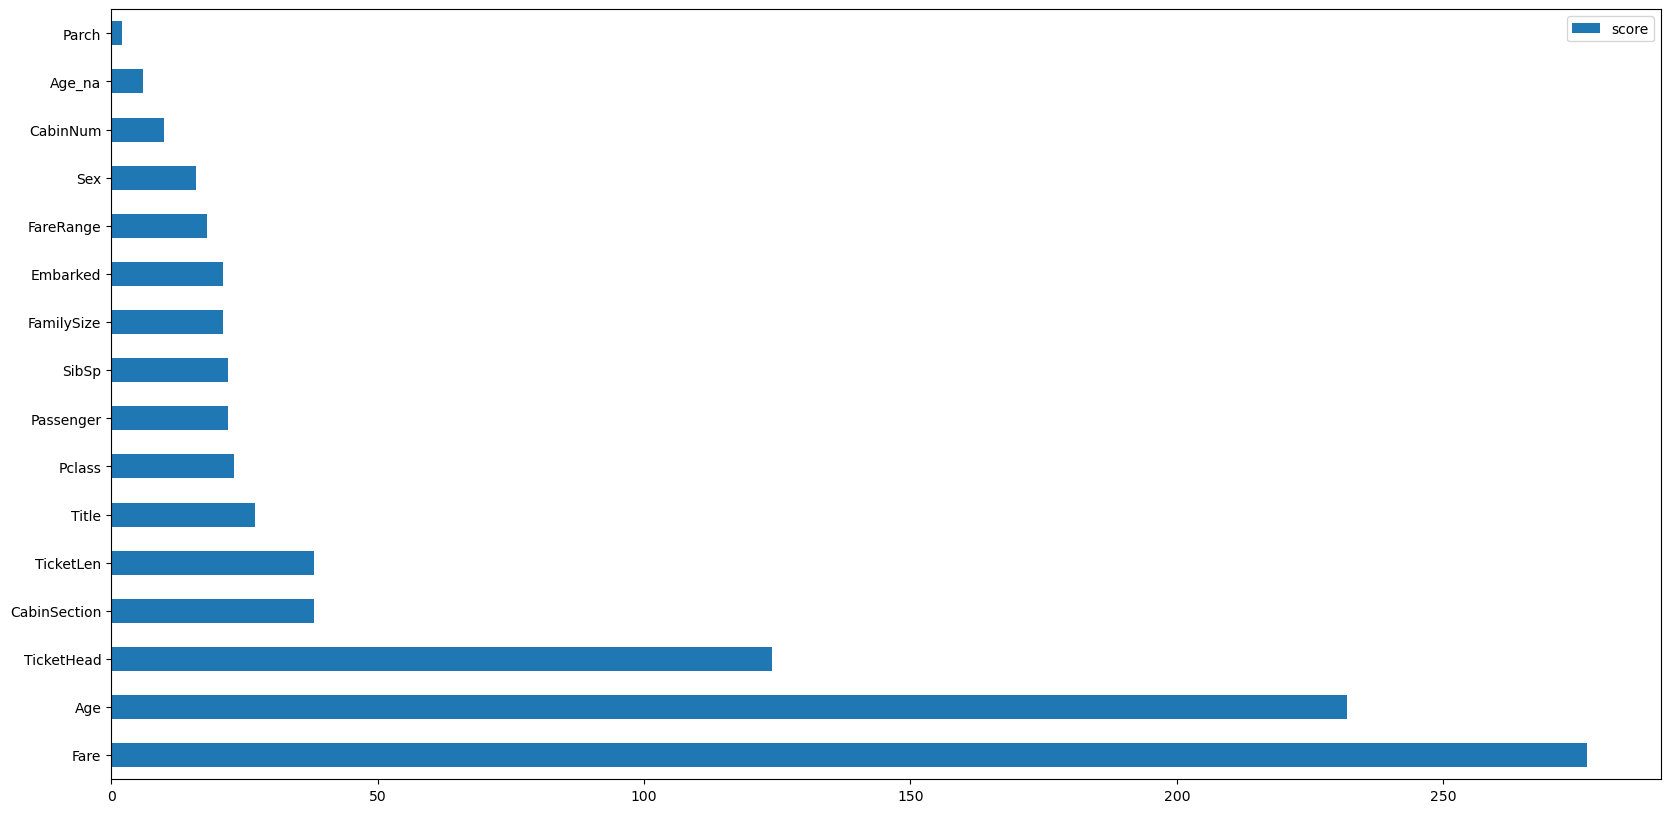

In [40]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [41]:
#config = tabular_config(ps=[0.001,0.01])
dls = to.dataloaders(bs = 64)
learn = tabular_learner(dls,
       layers=[2000, 1000],
                metrics = accuracy)
                #  layers=[2000, 1000],          
                # wd = [.001], 
                # config = config,

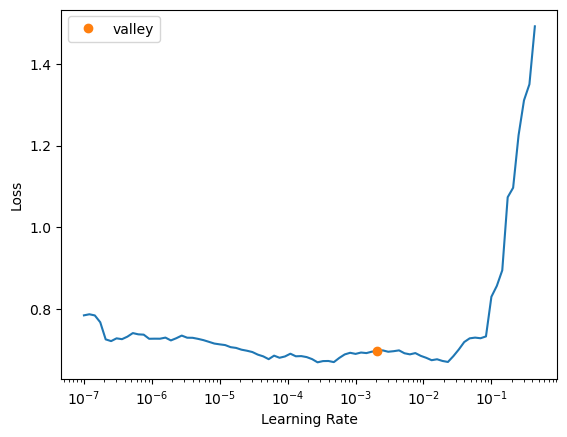

In [42]:
s=learn.lr_find()

In [43]:
#learn 20 epochs, but with earlystopping. patience is waitng 3 epochs before we stop
learn.fit(n_epoch=20, lr =s, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,accuracy,time
0,1.050093,0.656941,0.570895,00:00
1,0.808494,0.604790,0.686567,00:00
2,0.697128,0.575759,0.791045,00:00
3,0.624374,0.504106,0.776119,00:00
4,0.567251,0.502234,0.779851,00:00
5,0.527969,0.499681,0.791045,00:00
6,0.493309,0.497540,0.824627,00:00


No improvement since epoch 3: early stopping


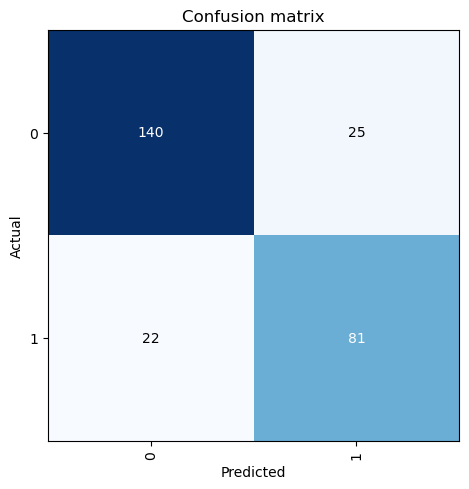

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [45]:
from fastinference.tabular import *


ImportError: The interp module is not installed.

In [ ]:
# test_df_y_n = (to_od.items['FlagRegister']).sort_index()
# test_df_n = (to_od.items.reindex(to.xs.columns, axis=1)).sort_index() #make sure it is to.xs not to_od, but theoretically should be same
dl_n = learn.dls.test_dl(X_test_sb)
raw_test_preds_n=learn.get_preds(dl =dl_n,with_decoded=True)

nn_preds_n=raw_test_preds_n[2]


AssertionError: nan values in `Fare` but not in setup training set

In [ ]:
# test_df_n = (test_data.reindex(X_val.columns, axis=1)).sort_index()
# test_df_n['Survived'] = 0
# to_test = TabularPandas(test_df_n, procs, cat_names, cont_names, y_names=dep_var,  y_block = CategoryBlock)
# X_testdata = to_test.train.xs
# xgb_preds_test = xgb_model.predict(X_testdata)

In [ ]:
# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': xgb_preds_test})
# output.to_csv('submission.csv', index=False)